## Import Tweets from JSON

Import the Tweets that we captured using the RTweet Library.
Note: This could also be done directly in Python using a library such as Tweepy.

In [7]:
import json
from pprint import pprint

with open('tweets.json') as f:
    data = json.load(f)

## Create Histogram of Common Domains in Tweets

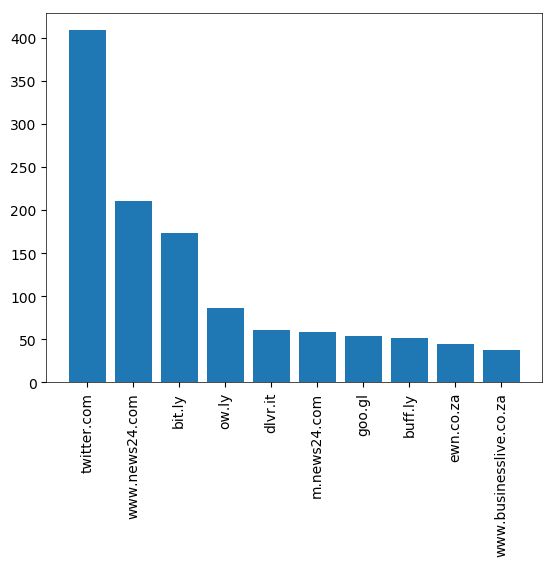

In [102]:
import re
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


domains = defaultdict(int)
sorted_domains = list()
sorted_counts = list()

for d in data:
    url = str(d["urls_expanded_url"][0])
    dom = re.match(r'http.*\/\/(.*?)\/', url)
    if dom:
        domain = dom.group(1)
        domains[domain] += 1

        
sdomains = sorted(domains, key=domains.get, reverse=True)

for w in sdomains:
    sorted_domains.append(w)
    sorted_counts.append(domains[w])
    # this will print all of the domains and their counts.
    # the tail may be the most interesting part
    # print w, domains[w]

# plot the most popular domains that show up in URLs
# plot shows only the top 10. domains has all of the counts

x = sorted_domains[:10]
y = sorted_counts[:10]

plt.bar(x,y)
plt.xticks(x, rotation='vertical')
plt.show()

## Lookup Characteristics of Each Domain Name

In [54]:
ips = dict()
nameservers = dict()

In [61]:
# requires: dnspython library

import dns.resolver

# Lookup IP addresses / A Records of Domain Names
for qname in sdomains:
    ips[qname] = list()
    
    try:
        answers = dns.resolver.query(qname, 'A')
    except dns.resolver.NXDOMAIN as e:
        # the domain does not exist so dns resolutions remain empty
        pass
    except dns.resolver.NoAnswer as e:
        # the resolver is not answering so dns resolutions remain empty
        pass

    for rdata in answers:
        #print qname, domains[qname], rdata.address
        ips[qname].append(rdata.address)
        
print ips['twitter.com'][0]

104.244.42.1


In [105]:
# dictionary of all of the DNS domain names -> IP addresses
print ips

{'www.wayamo.com': [u'129.121.176.228'], 'www.loyolaandnews.es': [u'91.192.110.199'], 'simplecast.com': [u'34.193.215.247', u'52.72.25.31', u'52.200.78.105', u'35.173.151.154', u'54.87.115.109', u'18.232.28.162'], 'nnd.ng': [u'54.213.66.64'], 'www.dispatchlive.co.za': [u'216.58.223.83'], 'www.thepresidency.gov.za': [u'41.0.5.139'], 'www.sabreakingnews.co.za': [u'104.199.94.19'], 'southerncourier.co.za': [u'104.24.11.33', u'104.24.10.33'], 'actionkingbest.blogspot.com': [u'216.58.223.1'], 'ift.tt': [u'67.199.248.12', u'67.199.248.13'], 'readinglist.click': [u'34.251.166.161'], 'theconversation.com': [u'151.101.130.110', u'151.101.2.110', u'151.101.66.110', u'151.101.194.110'], 'trib.al': [u'54.174.224.48', u'18.232.216.80', u'54.84.189.246'], 'blogs.worldbank.org': [u'104.17.188.11', u'104.17.187.11'], 'www.scmp.com': [u'47.89.56.101', u'103.206.40.111'], 'www.regularnews.net': [u'160.153.16.34'], 'www.flickr.com': [u'87.248.118.23', u'87.248.118.22', u'87.248.116.12', u'87.248.114.11']

In [72]:
# Lookup NS Records for Each Domain Name

for qname in sdomains:
    nameservers[qname] = list()
    
    answer = dns.resolver.query(qname, 'NS', raise_on_no_answer=False)
    if answer.rrset is not None:        
        for ns in answer.rrset.items:
              fqdn = ns.to_text().upper()
              nameservers[qname].append(fqdn)

['R01-01.NS.TWTRDNS.NET.', 'NS3.P34.DYNECT.NET.', 'A.R06.TWTRDNS.NET.', 'NS1.P34.DYNECT.NET.', 'D01-02.NS.TWTRDNS.NET.', 'NS4.P34.DYNECT.NET.', 'NS2.P34.DYNECT.NET.', 'D01-01.NS.TWTRDNS.NET.', 'R01-02.NS.TWTRDNS.NET.']


In [103]:
# dictionary of all of the DNS domain names -> DNS Namservers
print nameservers

{'www.wayamo.com': ['NS1.ASMALLORANGE.COM.', 'NS2.ASMALLORANGE.COM.'], 'www.loyolaandnews.es': ['DNS3.HISPALISDNS.COM.', 'DNS1.HISPALISDNS.COM.', 'DNS2.HISPALISDNS.COM.'], 'simplecast.com': ['NS-1649.AWSDNS-14.CO.UK.', 'NS-714.AWSDNS-25.NET.', 'NS-435.AWSDNS-54.COM.', 'NS-1055.AWSDNS-03.ORG.'], 'nnd.ng': ['AMIT.NS.CLOUDFLARE.COM.', 'ASA.NS.CLOUDFLARE.COM.'], 'www.dispatchlive.co.za': [], 'www.thepresidency.gov.za': [], 'www.sabreakingnews.co.za': [], 'southerncourier.co.za': ['THOMAS.NS.CLOUDFLARE.COM.', 'LISA.NS.CLOUDFLARE.COM.'], 'actionkingbest.blogspot.com': [], 'ift.tt': ['NS-60.AWSDNS-07.COM.', 'NS-1876.AWSDNS-42.CO.UK.', 'NS-1195.AWSDNS-21.ORG.', 'NS-901.AWSDNS-48.NET.'], 'readinglist.click': ['NS05.DOMAINCONTROL.COM.', 'NS06.DOMAINCONTROL.COM.'], 'theconversation.com': ['NS3.DNSIMPLE.COM.', 'NS4.DNSIMPLE.COM.', 'NS1.DNSIMPLE.COM.', 'NS2.DNSIMPLE.COM.', 'NS5.DNSUNLIMITED.COM.', 'NS1.DNSUNLIMITED.COM.'], 'trib.al': ['NS-637.AWSDNS-15.NET.', 'NS-1190.AWSDNS-20.ORG.', 'NS-1885.AWSD